### imports

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# datasets
from sklearn.datasets import load_iris
from ucimlrepo import fetch_ucirepo 
from io import StringIO

# discretization
from libraries.caimcaim import CAIMD # https://github.com/airysen/caimcaim/blob/master/caimcaim/caimcaim.py

# grid search
from sklearn.model_selection import GridSearchCV

# objective function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import torch

# evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

### datasets
- appendicitis: 7 medical measures taken over 106 patients on which the class label represents if the patient has appendicitis (class label 1) or not (class label 0).
- mammographic masses: discrimination of benign and malignant mammographic masses based on BI-RADS attributes and the patient's age.

In [275]:
with open('datasets/appendicitis.dat', "r") as file:
    lines = file.readlines()

data_start_ind = lines.index("@data\n") + 1
app_data = lines[data_start_ind:]
app_data = pd.read_csv(StringIO("".join(app_data)), header=None)

app_data.columns = ["At1", "At2", "At3", "At4", "At5", "At6", "At7", "Class"]

app_X = app_data.iloc[:, :-1]
app_y = app_data.iloc[:, -1]

print("num observations: ", app_y.count())
print("target distribution: ", app_y.value_counts())


app_X.describe()


num observations:  106
target distribution:  Class
0    85
1    21
Name: count, dtype: int64


,At1,At2,At3,At4,At5,At6,At7
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.398491,0.682104,0.415151,0.208745,0.169151,0.676349,0.375396
std,0.191452,0.207134,0.205799,0.199650,0.177329,0.218909,0.198132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.244750,0.589000,0.277000,0.056000,0.049250,0.576000,0.238000
50%,0.413000,0.750000,0.442500,0.146000,0.113000,0.744000,0.397500
75%,0.505750,0.821000,0.545500,0.302500,0.226750,0.831250,0.486750
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [276]:
# fetch dataset 
mammo_data = fetch_ucirepo(id=161) 
  
# data (as pandas dataframes) 
mammo_X = mammo_data.data.features 
mammo_y = mammo_data.data.targets 

print("num observations: ", mammo_y.count())

# drop rows with nulls
mammo_combined = pd.concat([mammo_X, mammo_y], axis=1)
print("num rows with nulls: ", mammo_combined.isnull().sum().sum())
mammo_combined = mammo_combined.dropna()
mammo_combined = mammo_combined.reset_index(drop=True)
mammo_X = mammo_combined.iloc[:, :-1]
mammo_y = mammo_combined.iloc[:, -1]


# metadata 
# print(mammo_data.metadata) 
  
# variable information 
# print(mammo_data.variables) 

print("num observations: ", mammo_y.count())
print("target distribution: ", mammo_y.value_counts())

mammo_X.describe()

num observations:  Severity    961
dtype: int64
num rows with nulls:  162
num observations:  830
target distribution:  Severity
0    427
1    403
Name: count, dtype: int64


,BI-RADS,Age,Shape,Margin,Density
count,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663
std,1.888371,14.671782,1.242361,1.567175,0.350936
min,0.000000,18.000000,1.000000,1.000000,1.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000


In [277]:
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

aesthetic_evaluation_data.head()

,Subjective Evaluation,BRA Value,LBC Value,UNR Value,BCE Value,BCD Value,BAD Value,BOD Value,pBRA Value,pLBC Value,...,pBAD Value,pBOD Value,cX2L Value,cX2a Value,cX2b Value,cX2Lab Value,cEMDL Value,cEMDa Value,cEMDb Value,cEMDLab Value
0,Good,1.149009,0.830915,0.107618,0.938534,1.934477,4.885198,17.296370,0.049401,0.033356,...,0.029188,0.103340,0.097502,0.009506,0.217169,0.100670,1.503086,0.030362,0.291363,0.210082
1,Good,2.368824,1.326447,1.599444,0.272997,0.035378,19.932998,68.761479,0.113919,0.058509,...,0.117875,0.406627,0.305692,0.159653,0.193317,0.061736,1.248600,0.206529,0.351693,0.105346
2,Good,1.409939,0.950935,0.278358,1.229293,2.221074,22.277770,38.323430,0.067231,0.038613,...,0.120132,0.206658,0.109386,0.024217,0.280625,0.012974,0.545858,0.075520,0.304185,0.049345
3,Good,2.059918,0.720926,1.786307,1.065381,1.995007,25.163410,31.631070,0.100705,0.032141,...,0.156030,0.196133,0.038581,0.032267,0.026153,0.010779,0.334111,0.105626,0.137693,0.031455
4,Good,2.452595,0.798596,1.868745,1.070148,1.218189,0.395585,31.426783,0.117249,0.035235,...,0.002820,0.224062,0.021259,0.027071,0.029206,0.006495,0.165401,0.081549,0.091768,0.030546


In [278]:
aesthetic_evaluation_y.value_counts()

Subjective Evaluation
Good         595
Fair         353
Excellent    308
Poor         102
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Subjective Evaluation')

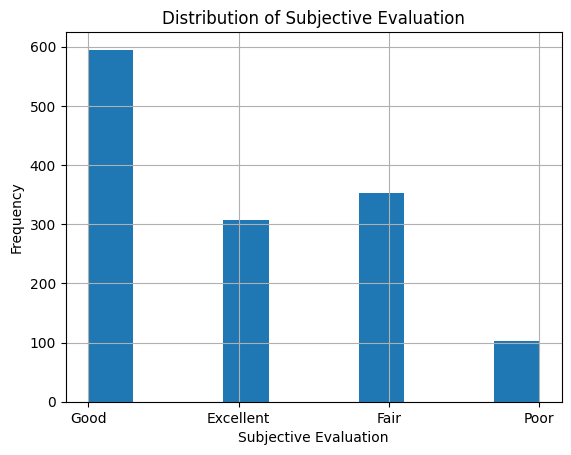

In [279]:
aesthetic_evaluation_y.hist()
plt.xlabel('Subjective Evaluation')
plt.ylabel('Frequency')
plt.title('Distribution of Subjective Evaluation')

In [280]:
# create binary target from aesthetic evaluation, by joining good and excellent, and fair and poor
aesthetic_evaluation_binary_y = aesthetic_evaluation_y.map({'Excellent': 1, 'Good': 1, 'Fair': 0, 'Poor': 0})

# distribution
aesthetic_evaluation_binary_y.value_counts()

Subjective Evaluation
1    903
0    455
Name: count, dtype: int64

### sbc reduction and classification

In [337]:
def sbc_reduction(X, y, h=1):
    # num of classes
    K = len(np.unique(y))
    print("num classes: ", K)
    
    # num of parallel hyperplanes to be created (and replicas)
    s = K-1
    
    # if class labels not integer, convert to integer
    if not np.issubdtype(y.dtype, np.integer):
        y = pd.Series(pd.factorize(y)[0])
        
    # for each point, create s replicas each with a new feature in [0, h, h*2, ... h*(s-1)]
    # the new label is a binary label
    new_X = []
    new_y = []
    for i in range(X.shape[0]): # for each point
        for j in range(s): # for each replica
            new_X.append(np.append(X.iloc[i].values, h*j))
            new_label = y.iloc[i] < j
            new_y.append(new_label.astype(int))
    
    new_X = pd.DataFrame(new_X).reset_index(drop=True)
    new_y = pd.DataFrame(new_y).reset_index(drop=True)
    new_data = pd.concat([new_X, new_y], axis=1)
    
    return new_X, new_y, new_data

In [336]:
def sbc_classif(og_X, og_y, sbc_X, pred_sbc_y):
    K = len(np.unique(og_y)) # num of classes
    s = K-1 # num of hyperplanes / replicas
    
    # get classification of all replicas of each point
    all_labels = [pred_sbc_y[i:i + s] for i in range(0, len(pred_sbc_y), s)]
    all_labels = np.array(all_labels)
    print(all_labels)
    
    # get the class of the point --> number of replicas with label 1
    # if all replicas are 0, then the class is 0
    # if one is 1 and the rest are 0, then the class is 1
    # if two are 1 and the rest are 0, then the class is 2
    # ...
    # if all replicas are 1, then the class is K
    final_labels = np.argmax(all_labels, axis=1)    
    
    return final_labels

In [341]:
aesthetic_evaluation_new_X, aesthetic_evaluation_new_y, aesthetic_evaluation_new_data = sbc_reduction(aesthetic_evaluation_X, aesthetic_evaluation_y, h=1)

num classes:  4


### discretization thresholds
- CAIM
- infinitesimal bins

In [283]:
# discretize using CAIM
def discretize_caim_df(data, X, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    
    print("\nCut-off points: ", caim.split_scheme)
    print("Number of bins: ", end="")
    for i, (key, value) in enumerate(caim.split_scheme.items()):
        if i == len(caim.split_scheme) - 1:
            print(f" {key}: {len(value)+1}", end="")
        else:
            print(f" {key}: {len(value)+1}", end=",")
    print()
    
    X_disc_caim = pd.DataFrame(X_disc_caim, columns=X.columns).astype(int) # convert to pandas dataframe and int
        
    return X_disc_caim

''' 
prints of fit() method: Categorical list_of_(indicies)_categorical_features
    # feature_index  GLOBAL CAIM  best_caim_value 
in the returning dataframe:
    - columns represent the original features
    - rows represent each instance
    - values are the bin number each instance belongs to (starting from 0)
'''

def discretize_caim(X, cols, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    # get thresholds from caim.split_scheme (dict with column index : thresholds)
    # transform all values to floats
    # and keys with column indexes to column names
    thresholds = {cols[i]: [float(val) for val in value] for i, (key, value) in enumerate(caim.split_scheme.items())}
    print("\nthresholds ", thresholds)
    print("num of bins: ")
    for i, (key, value) in enumerate(thresholds.items()):
        print(f"  {key}: {len(value)+1}")
    return thresholds


In [284]:
# discretize using infinitesimal bins:
# thresholds are the points in between 2 consecutive values in the sorted list
def discretize_infbins(X, cols, y):
    infbins_thresholds = {}
    for col in cols:
        # sort unique values
        sorted_col = np.unique(X[col])
        # get thresholds
        thresholds = (sorted_col[:-1] + sorted_col[1:]) / 2
        infbins_thresholds[col] = thresholds.tolist()
    
    print("\nthresholds ", infbins_thresholds)
    print("num of bins: ")
    for key, value in infbins_thresholds.items():
        print(f"  {key}: {len(value)+1}")

    return infbins_thresholds

### discretized version
- 1 out of k
- differential coding

In [285]:
def get_bins(thresholds, values):
    bins = np.digitize(values, thresholds)
    return bins
    # list of bin number for each row

In [286]:
def disc_1_out_of_k(X, cols, thresholds):
    disc_df = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        bins_df = pd.get_dummies(bins, prefix=f'feat{col}-bin', prefix_sep='').astype(int) # one hot encoding
        for i in range(1, len(thresholds[col]) + 1):
            if f'feat{col}-bin{i}' not in bins_df.columns:
                bins_df[f'feat{col}-bin{i}'] = 0
        bins_df = bins_df.drop(columns=f'feat{col}-bin0', errors='ignore')
        disc_df.append(bins_df)    
    return pd.concat(disc_df, axis=1)


In [287]:
def disc_diff_coding(X, cols, thresholds):
    bin_dfs = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        num_bins = len(thresholds[col]) + 1
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bins >= i).astype(int)
        bin_dfs.append(bin_df)
    return pd.concat(bin_dfs, axis=1)

### objective functions
- LS
- maximum likelihood
- margin maximization

In [288]:
def grid_search(model, X, y, param_grid, cv=10):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)
    return grid_search

In [289]:
def get_weights(model, disc_X, y):
    model.fit(disc_X, y)
    weights = model.coef_[0]
    feature_names = disc_X.columns
    weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': weights})
    return weights_df

In [ ]:
# RSS --> não está a funcionar pq Lasso tá à espera de valores contínuos
def rss(X, y): 
    linear_regression = Lasso()
    param_grid = {'alpha': [0.001, 0.01, 0.1, 0.4, 0.6, 0.9, 0.99, 1.0]}
    grid_search_rss = grid_search(linear_regression, X, y, param_grid)
    print("RSS best parameters: ", grid_search_rss.best_params_)
    best_model_rss = grid_search_rss.best_estimator_
    weights_rss = get_weights(best_model_rss, X, y)
    print("RSS weights:\n", weights_rss)

    # plot
    plt.figure()
    plt.bar(weights_rss['Feature'], weights_rss['Weight'])
    plt.xticks(rotation=90)
    plt.title('RSS weights')
    plt.show()

    return best_model_rss, weights_rss

In [291]:
# maximum likelihood (GLM with binomial response and logit link function)
def max_likelihood(X, y):
    logistic = LogisticRegression(solver = 'liblinear', penalty = 'l1')
    alpha_values = [0.001, 0.01, 0.1, 0.4, 0.6, 0.9, 1.0]
    param_grid = {'C': [1/a for a in alpha_values]} # inverse of regularization strength
    grid_search_logistic = grid_search(logistic, X, y, param_grid)
    print("ML best parameters: ", grid_search_logistic.best_params_)
    best_alpha = 1/grid_search_logistic.best_params_['C']
    print("ML best alpha: ", best_alpha)
    best_model_ml = grid_search_logistic.best_estimator_
    weights_ml = get_weights(best_model_ml, X, y)
    print("ML weights:\n", weights_ml)


    # plot weights
    plt.figure()
    plt.bar(weights_ml['Feature'], weights_ml['Weight'])
    plt.xticks(rotation=90)
    plt.title('ML weights')
    plt.show()

    return best_model_ml, weights_ml

In [292]:
# margin maximization (linear SVM)
def margin_max(X, y):
    param_grid = {
        'C': [2**i for i in range(-10, 11)],
        'class_weight': ['balanced', None],
    }
    svm = SVC(kernel='linear')
    #svm = svm_problem(app_y, disc_app_X)
    grid_search_svm = grid_search(svm, X, y, param_grid)
    best_model_svm = grid_search_svm.best_estimator_
    weights_svm = get_weights(best_model_svm, X, y)
    print("SVM weights:\n", weights_svm)

    # plot
    plt.figure()
    plt.bar(weights_svm['Feature'], weights_svm['Weight'])
    plt.xticks(rotation=90)
    plt.title('SVM weights')
    plt.show()

    return best_model_svm, weights_svm

### scorecard

In [293]:
def scorecard(X, y, disc_thresholds_method, disc_version_method, obj_function_method, sbc=False):
    if sbc:
        X, y, _ = sbc_reduction(X, y)
    # discretize
    thresholds = disc_thresholds_method(X, X.columns, y)
    disc_X = disc_version_method(X, X.columns, thresholds)
   
    # get weights
    model, weights = obj_function_method(disc_X, y)
    weights2 = weights[weights['Weight'] != 0]
    if weights2.shape[0] < weights.shape[0]:
        print("num of non-zero weights: ", weights2.shape[0])
        print("num of zero weights: ", weights.shape[0] - weights2.shape[0])
        print(weights2)
        plt.figure()
        plt.bar(weights2['Feature'], weights2['Weight'])
        plt.xticks(rotation=90)
        plt.show()

    return model, weights


### evaluation

In [294]:
def cross_val_score(model, X, y, n_splits=10):
    kf = StratifiedKFold(n_splits=n_splits)
    MSEs = [] # mean squared error
    accuracies = [] 
    AUCs = [] # area under the ROC curve
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        MSEs.append(mean_squared_error(y_test, y_pred))
        accuracies.append((y_pred == y_test).mean())
        #AUCs.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
        if hasattr(model, "predict_proba"):
            AUCs.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
        else:
            AUCs.append(roc_auc_score(y_test, y_pred))
        
    print("MSEs: ", MSEs)
    print("accuracies: ", accuracies)
    print("AUCs: ", AUCs)
    
    print("mean MSE: ", np.mean(MSEs))
    print("mean accuracy: ", np.mean(accuracies))
    print("mean AUC: ", np.mean(AUCs))
    return np.mean(MSEs), np.mean(accuracies), np.mean(AUCs)

### test

##### dataset: **appendicitis**; disc threshold: **CAIM**; disc method: **1 out of k**

In [295]:
app_thresholds = discretize_caim(app_X, app_X.columns, app_y)
app_disc_X = disc_1_out_of_k(app_X, app_X.columns, app_thresholds)

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4


RSS

In [296]:
#app_model_caim_1ook_rss, app_weights_caim_1ook_rss = scorecard(app_X, app_y, discretize_caim, disc_1_out_of_k, rss)

In [297]:
#app_scores_caim_1ook_rss, app_accuracies_caim_1ook_rss, app_AUCs_caim_1ook_rss = cross_val_score(app_model_caim_1ook_rss, app_X, app_y)

ML

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4
ML best parameters:  {'C': 10.0}
ML best alpha:  0.1
ML weights:
          Feature    Weight
0   featAt1-bin1  1.402976
1   featAt1-bin2 -0.650556
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.268005
4   featAt2-bin2 -0.504138
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.336342
7   featAt3-bin2  0.000000
8   featAt3-bin3  0.000000
9   featAt4-bin1  0.249793
10  featAt4-bin2 -1.738084
11  featAt4-bin3  0.000000
12  featAt5-bin1 -0.332604
13  featAt5-bin

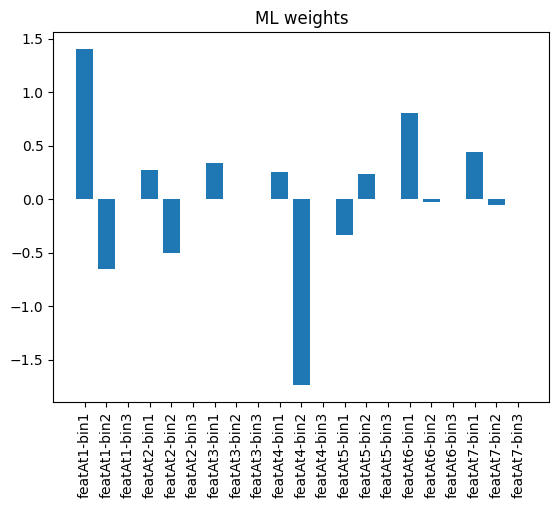

num of non-zero weights:  13
num of zero weights:  8
         Feature    Weight
0   featAt1-bin1  1.402976
1   featAt1-bin2 -0.650556
3   featAt2-bin1  0.268005
4   featAt2-bin2 -0.504138
6   featAt3-bin1  0.336342
9   featAt4-bin1  0.249793
10  featAt4-bin2 -1.738084
12  featAt5-bin1 -0.332604
13  featAt5-bin2  0.235028
15  featAt6-bin1  0.800454
16  featAt6-bin2 -0.029843
18  featAt7-bin1  0.441933
19  featAt7-bin2 -0.052829


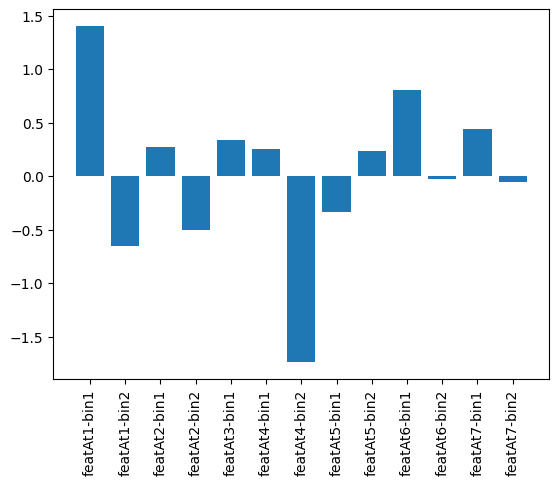

In [298]:
app_model_caim_1ook_ml, app_weights_caim_1ook_ml = scorecard(app_X, app_y, discretize_caim, disc_1_out_of_k, max_likelihood)

In [299]:
app_scores_caim_1ook_ml, app_accuracies_caim_1ook_ml, app_AUCs_caim_1ook_ml = cross_val_score(app_model_caim_1ook_ml, app_X, app_y)

MSEs:  [0.18181818181818182, 0.09090909090909091, 0.0, 0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.0, 0.2, 0.3, 0.2]
accuracies:  [0.8181818181818182, 0.9090909090909091, 1.0, 0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 1.0, 0.8, 0.7, 0.8]
AUCs:  [0.8333333333333333, 0.9444444444444444, 1.0, 0.5, 0.9444444444444444, 0.5, 1.0, 0.875, 0.625, 0.875]
mean MSE:  0.14272727272727273
mean accuracy:  0.8572727272727272
mean AUC:  0.8097222222222221


MM

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4
SVM weights:
          Feature    Weight
0   featAt1-bin1  0.266763
1   featAt1-bin2 -0.266763
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.128510
4   featAt2-bin2 -0.128510
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.207379
7   featAt3-bin2 -0.207379
8   featAt3-bin3  0.000000
9   featAt4-bin1  0.109489
10  featAt4-bin2 -0.109489
11  featAt4-bin3  0.000000
12  featAt5-bin1  0.079797
13  featAt5-bin2 -0.079797
14  featAt5-bin3  0.000000
15  featAt6-b

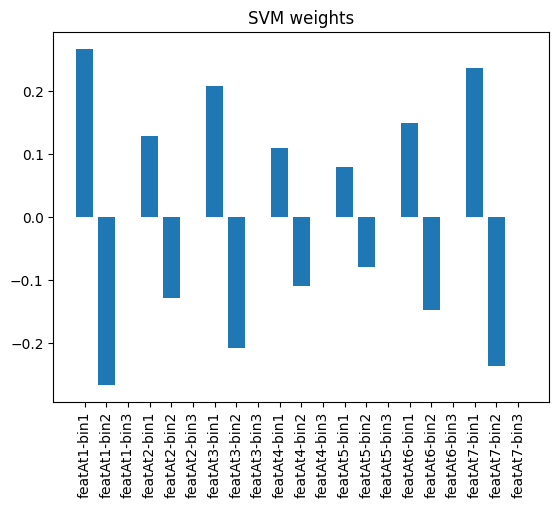

num of non-zero weights:  14
num of zero weights:  7
         Feature    Weight
0   featAt1-bin1  0.266763
1   featAt1-bin2 -0.266763
3   featAt2-bin1  0.128510
4   featAt2-bin2 -0.128510
6   featAt3-bin1  0.207379
7   featAt3-bin2 -0.207379
9   featAt4-bin1  0.109489
10  featAt4-bin2 -0.109489
12  featAt5-bin1  0.079797
13  featAt5-bin2 -0.079797
15  featAt6-bin1  0.148459
16  featAt6-bin2 -0.148459
18  featAt7-bin1  0.237071
19  featAt7-bin2 -0.237071


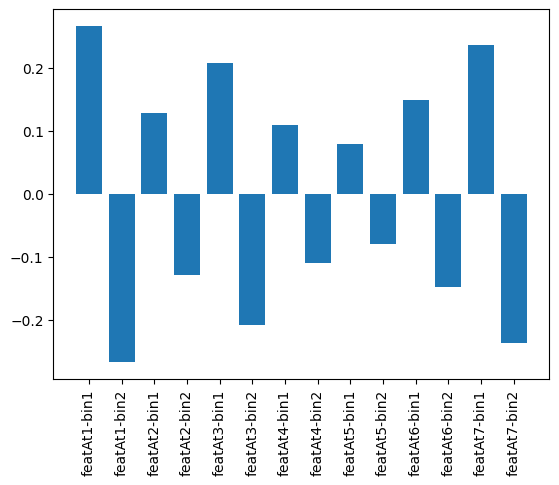

In [300]:
app_model_caim_1ook_mm, app_weights_caim_1ook_mm = scorecard(app_X, app_y, discretize_caim, disc_1_out_of_k, margin_max)

In [301]:
app_scores_caim_1ook_mm, app_accuracies_caim_1ook_mm, app_AUCs_caim_1ook_mm = cross_val_score(app_model_caim_1ook_mm, app_X, app_y)

MSEs:  [0.2727272727272727, 0.2727272727272727, 0.2727272727272727, 0.45454545454545453, 0.0, 0.09090909090909091, 0.2, 0.2, 0.2, 0.2]
accuracies:  [0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.5454545454545454, 1.0, 0.9090909090909091, 0.8, 0.8, 0.8, 0.8]
AUCs:  [0.5, 0.8333333333333334, 0.8333333333333334, 0.5277777777777778, 1.0, 0.75, 0.5, 0.5, 0.5, 0.5]
mean MSE:  0.21636363636363637
mean accuracy:  0.7836363636363636
mean AUC:  0.6444444444444445


##### dataset: **appendicitis**; disc threshold: **CAIM**; disc method: **differential coding**

RSS

In [302]:
# app_model_caim_diffcoding_rss, app_weights_caim_diffcoding_rss = scorecard(app_X, app_y, discretize_caim, disc_diff_coding, rss)

In [303]:
# app_scores_caim_diffcoding_rss, app_accuracies_caim_diffcoding_rss, app_AUCs_caim_diffcoding_rss = cross_val_score(app_model_caim_diffcoding_rss, app_X, app_y)

ML

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4
ML best parameters:  {'C': 10.0}
ML best alpha:  0.1
ML weights:
          Feature    Weight
0   featAt1-bin1  0.620930
1   featAt1-bin2 -2.048487
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.014790
4   featAt2-bin2 -0.761071
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.847630
7   featAt3-bin2 -0.246375
8   featAt3-bin3  0.000000
9   featAt4-bin1  0.323338
10  featAt4-bin2 -1.938024
11  featAt4-bin3  0.000000
12  featAt5-bin1  0.277284
13  featAt5-bin

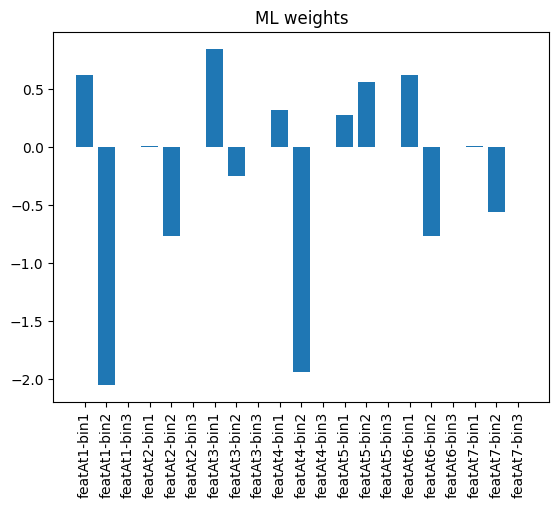

num of non-zero weights:  14
num of zero weights:  7
         Feature    Weight
0   featAt1-bin1  0.620930
1   featAt1-bin2 -2.048487
3   featAt2-bin1  0.014790
4   featAt2-bin2 -0.761071
6   featAt3-bin1  0.847630
7   featAt3-bin2 -0.246375
9   featAt4-bin1  0.323338
10  featAt4-bin2 -1.938024
12  featAt5-bin1  0.277284
13  featAt5-bin2  0.565207
15  featAt6-bin1  0.620971
16  featAt6-bin2 -0.764992
18  featAt7-bin1  0.013113
19  featAt7-bin2 -0.556344


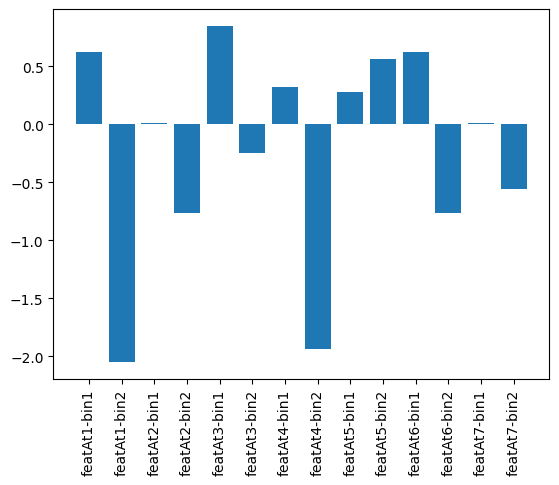

In [304]:
app_model_caim_diffcoding_ml, app_weights_caim_diffcoding_ml = scorecard(app_X, app_y, discretize_caim, disc_diff_coding, max_likelihood)

In [305]:
app_scores_caim_diffcoding_ml, app_accuracies_caim_diffcoding_ml, app_AUCs_caim_diffcoding_ml = cross_val_score(app_model_caim_diffcoding_ml, app_X, app_y)

MSEs:  [0.18181818181818182, 0.09090909090909091, 0.0, 0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.0, 0.2, 0.3, 0.2]
accuracies:  [0.8181818181818182, 0.9090909090909091, 1.0, 0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 1.0, 0.8, 0.7, 0.8]
AUCs:  [0.8333333333333333, 0.9444444444444444, 1.0, 0.5, 0.9444444444444444, 0.5, 1.0, 0.875, 0.625, 0.875]
mean MSE:  0.14272727272727273
mean accuracy:  0.8572727272727272
mean AUC:  0.8097222222222221


MM

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4
SVM weights:
          Feature        Weight
0   featAt1-bin1 -8.326673e-16
1   featAt1-bin2 -5.335259e-01
2   featAt1-bin3  0.000000e+00
3   featAt2-bin1 -8.326673e-16
4   featAt2-bin2 -2.570203e-01
5   featAt2-bin3  0.000000e+00
6   featAt3-bin1 -8.326673e-16
7   featAt3-bin2 -4.147584e-01
8   featAt3-bin3  0.000000e+00
9   featAt4-bin1 -8.326673e-16
10  featAt4-bin2 -2.189776e-01
11  featAt4-bin3  0.000000e+00
12  featAt5-bin1 -8.326673e-16
13  featAt5

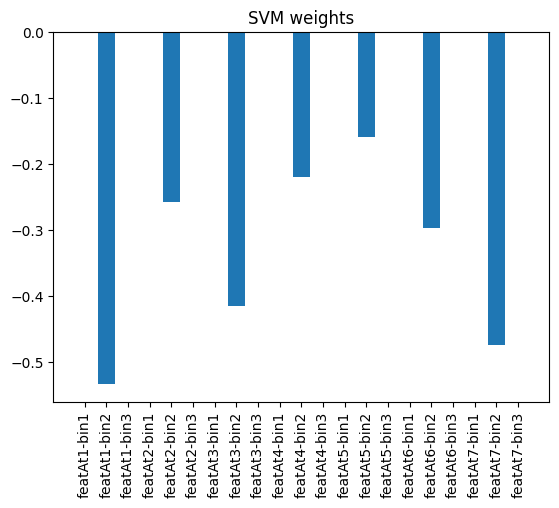

num of non-zero weights:  14
num of zero weights:  7
         Feature        Weight
0   featAt1-bin1 -8.326673e-16
1   featAt1-bin2 -5.335259e-01
3   featAt2-bin1 -8.326673e-16
4   featAt2-bin2 -2.570203e-01
6   featAt3-bin1 -8.326673e-16
7   featAt3-bin2 -4.147584e-01
9   featAt4-bin1 -8.326673e-16
10  featAt4-bin2 -2.189776e-01
12  featAt5-bin1 -8.326673e-16
13  featAt5-bin2 -1.595938e-01
15  featAt6-bin1 -8.326673e-16
16  featAt6-bin2 -2.969188e-01
18  featAt7-bin1 -8.326673e-16
19  featAt7-bin2 -4.741422e-01


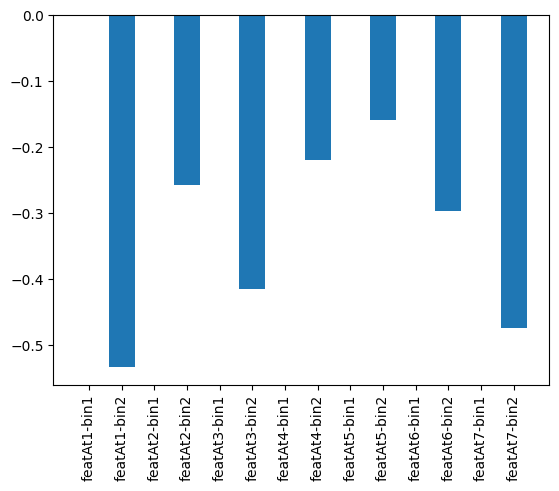

In [306]:
app_model_caim_diffcoding_mm, app_weights_caim_diffcoding_mm = scorecard(app_X, app_y, discretize_caim, disc_diff_coding, margin_max)

In [307]:
app_scores_caim_diffcoding_mm, app_accuracies_caim_diffcoding_mm, app_AUCs_caim_diffcoding_mm = cross_val_score(app_model_caim_diffcoding_mm, app_X, app_y)

MSEs:  [0.18181818181818182, 0.2727272727272727, 0.2727272727272727, 0.45454545454545453, 0.0, 0.09090909090909091, 0.0, 0.3, 0.4, 0.1]
accuracies:  [0.8181818181818182, 0.7272727272727273, 0.7272727272727273, 0.5454545454545454, 1.0, 0.9090909090909091, 1.0, 0.7, 0.6, 0.9]
AUCs:  [0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 0.5277777777777778, 1.0, 0.75, 1.0, 0.625, 0.5625, 0.9375]
mean MSE:  0.20727272727272728
mean accuracy:  0.7927272727272727
mean AUC:  0.773611111111111


##### dataset: **appendicitis**; disc threshold: **infinitesimal bins**; disc method: **1 out of k**

RSS

In [308]:
# app_model_infbins_1ook_rss, app_weights_infbins_1ook_rss = scorecard(app_X, app_y, discretize_infbins, disc_1_out_of_k, rss)

In [309]:
# app_scores_infbins_1ook_rss, app_accuracies_infbins_1ook_rss, app_AUCs_infbins_1ook_rss = cross_val_score(app_model_infbins_1ook_rss, app_X, app_y)

ML


thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 

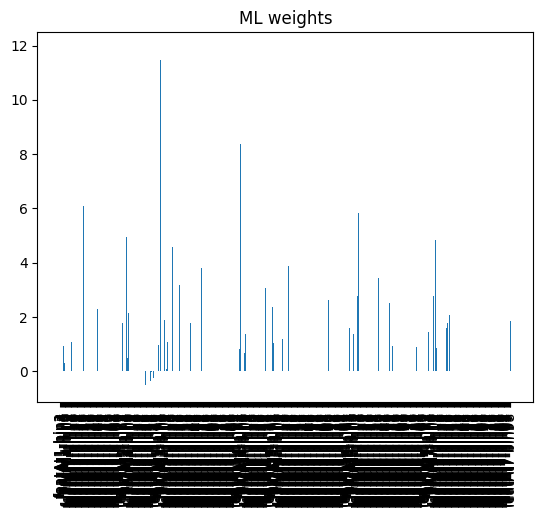

num of non-zero weights:  70
num of zero weights:  453
           Feature     Weight
1     featAt1-bin2   3.962583
4     featAt1-bin5   0.932399
5     featAt1-bin6   0.321866
8     featAt1-bin9   1.393639
10   featAt1-bin11  11.868285
..             ...        ...
449  featAt7-bin25   1.792931
451  featAt7-bin27   2.066029
467  featAt7-bin43   4.633344
468  featAt7-bin44   2.052851
522  featAt7-bin98   1.843806

[70 rows x 2 columns]


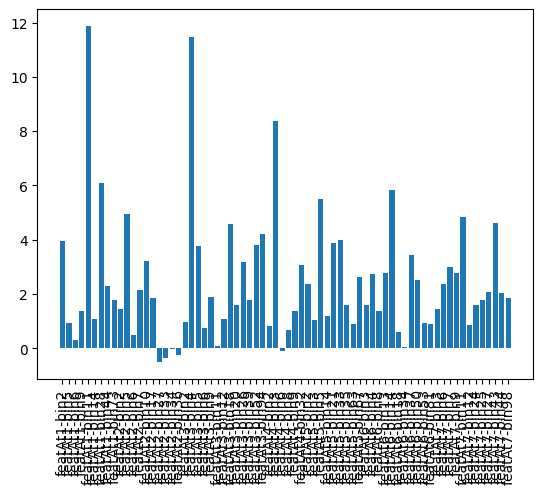

In [310]:
app_model_infbins_1ook_ml, app_weights_infbins_1ook_ml = scorecard(app_X, app_y, discretize_infbins, disc_1_out_of_k, max_likelihood)

In [311]:
app_scores_infbins_1ook_ml, app_accuracies_infbins_1ook_ml, app_AUCs_infbins_1ook_ml = cross_val_score(app_model_infbins_1ook_ml, app_X, app_y)

MSEs:  [0.18181818181818182, 0.09090909090909091, 0.0, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.0, 0.2, 0.2, 0.2]
accuracies:  [0.8181818181818182, 0.9090909090909091, 1.0, 0.8181818181818182, 0.9090909090909091, 0.9090909090909091, 1.0, 0.8, 0.8, 0.8]
AUCs:  [0.8333333333333333, 0.9444444444444444, 1.0, 0.5555555555555556, 0.9444444444444444, 0.5, 1.0, 0.875, 0.6875, 0.875]
mean MSE:  0.12363636363636363
mean accuracy:  0.8763636363636363
mean AUC:  0.8215277777777779


MM


thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 

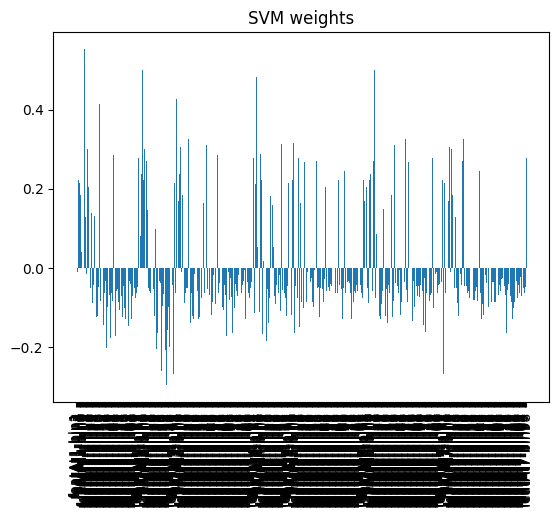

num of non-zero weights:  512
num of zero weights:  11
           Feature    Weight
0     featAt1-bin1 -0.062627
1     featAt1-bin2  0.313258
2     featAt1-bin3 -0.010897
3     featAt1-bin4  0.222931
4     featAt1-bin5  0.215703
..             ...       ...
518  featAt7-bin94 -0.035483
519  featAt7-bin95 -0.050812
520  featAt7-bin96 -0.063462
521  featAt7-bin97 -0.048621
522  featAt7-bin98  0.278121

[512 rows x 2 columns]


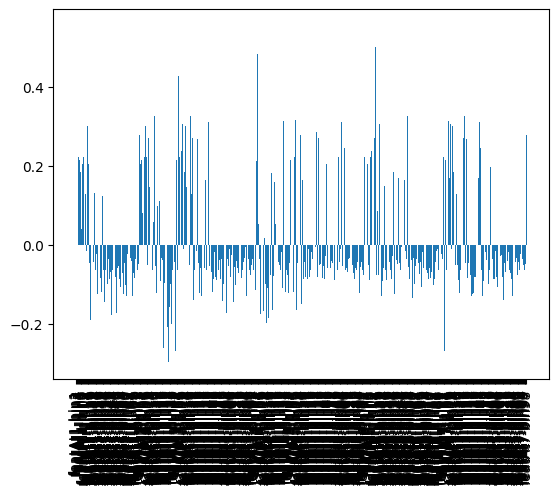

In [312]:
app_model_infbins_1ook_mm, app_weights_infbins_1ook_mm = scorecard(app_X, app_y, discretize_infbins, disc_1_out_of_k, margin_max)

In [313]:
app_scores_infbins_1ook_mm, app_accuracies_infbins_1ook_mm, app_AUCs_infbins_1ook_mm = cross_val_score(app_model_infbins_1ook_mm, app_X, app_y)

MSEs:  [0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.2727272727272727, 0.09090909090909091, 0.09090909090909091, 0.2, 0.1, 0.2, 0.3]
accuracies:  [0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 0.8, 0.9, 0.8, 0.7]
AUCs:  [0.5, 0.75, 0.75, 0.4444444444444444, 0.75, 0.75, 0.5, 0.75, 0.6875, 0.4375]
mean MSE:  0.17090909090909093
mean accuracy:  0.8290909090909091
mean AUC:  0.6319444444444444


##### dataset: **appendicitis**; disc threshold: **infinitesimal bins**; disc method: **differential coding**

RSS

In [314]:
# app_model_infbins_diffcoding_rss, app_weights_infbins_diffcoding_rss = scorecard(app_X, app_y, discretize_infbins, disc_diff_coding, rss)

In [315]:
# app_scores_infbins_diffcoding_rss, app_accuracies_infbins_diffcoding_rss, app_AUCs_infbins_diffcoding_rss = cross_val_score(app_model_infbins_diffcoding_rss, app_X, app_y)

ML


thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 

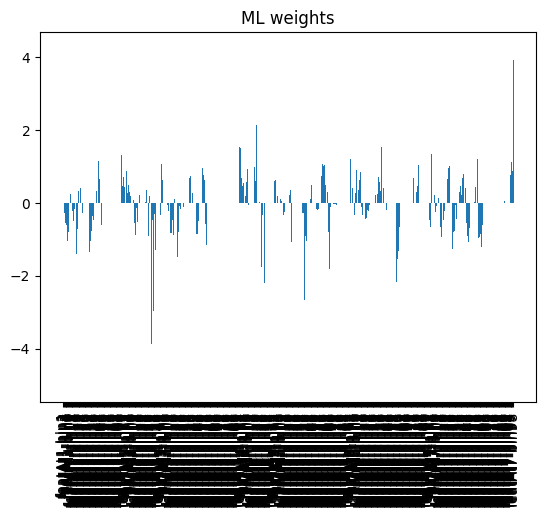

num of non-zero weights:  293
num of zero weights:  230
           Feature    Weight
0     featAt1-bin1 -0.276560
1     featAt1-bin2 -0.222692
2     featAt1-bin3 -0.285081
3     featAt1-bin4 -0.549440
4     featAt1-bin5 -0.592095
..             ...       ...
512  featAt7-bin88  0.055449
519  featAt7-bin95  0.778758
520  featAt7-bin96  1.114433
521  featAt7-bin97  0.885513
522  featAt7-bin98  3.927425

[293 rows x 2 columns]


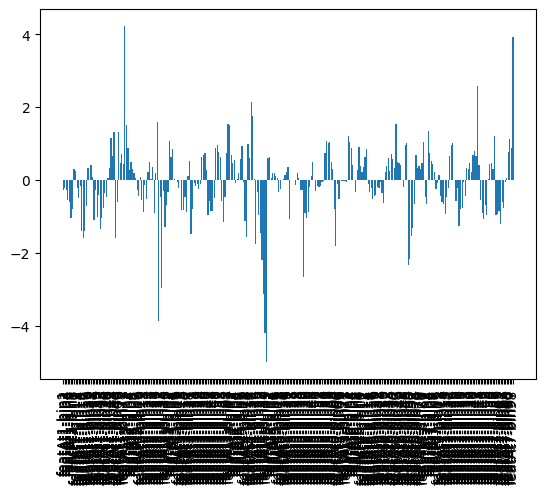

In [316]:
app_model_infbins_diffcoding_ml, app_weights_infbins_diffcoding_ml = scorecard(app_X, app_y, discretize_infbins, disc_diff_coding, max_likelihood)

In [317]:
app_scores_infbins_diffcoding_ml, app_accuracies_infbins_diffcoding_ml, app_AUCs_infbins_diffcoding_ml = cross_val_score(app_model_infbins_diffcoding_ml, app_X, app_y)

MSEs:  [0.18181818181818182, 0.09090909090909091, 0.0, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.1, 0.1, 0.2, 0.2]
accuracies:  [0.8181818181818182, 0.9090909090909091, 1.0, 0.8181818181818182, 0.9090909090909091, 0.9090909090909091, 0.9, 0.9, 0.8, 0.8]
AUCs:  [0.7916666666666667, 0.9444444444444444, 1.0, 0.5555555555555556, 0.9444444444444444, 0.5, 0.875, 0.875, 0.75, 0.8125]
mean MSE:  0.12363636363636363
mean accuracy:  0.8763636363636363
mean AUC:  0.804861111111111


/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


MM


thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 

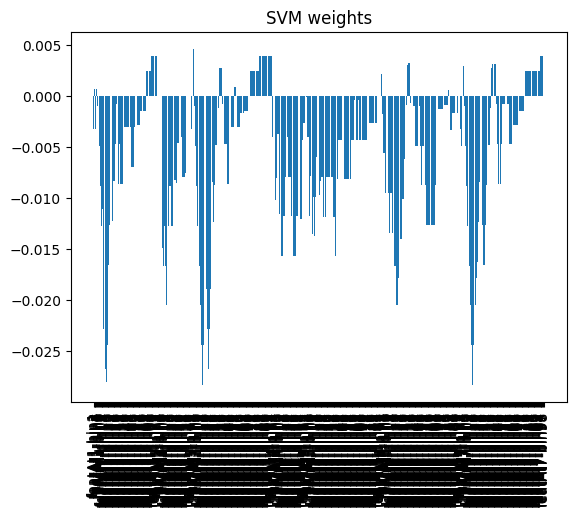

num of non-zero weights:  510
num of zero weights:  13
           Feature    Weight
0     featAt1-bin1 -0.003196
1     featAt1-bin2  0.000710
2     featAt1-bin3 -0.003196
3     featAt1-bin4  0.000710
4     featAt1-bin5 -0.000992
..             ...       ...
518  featAt7-bin94  0.003906
519  featAt7-bin95  0.003906
520  featAt7-bin96  0.003906
521  featAt7-bin97  0.003906
522  featAt7-bin98  0.003906

[510 rows x 2 columns]


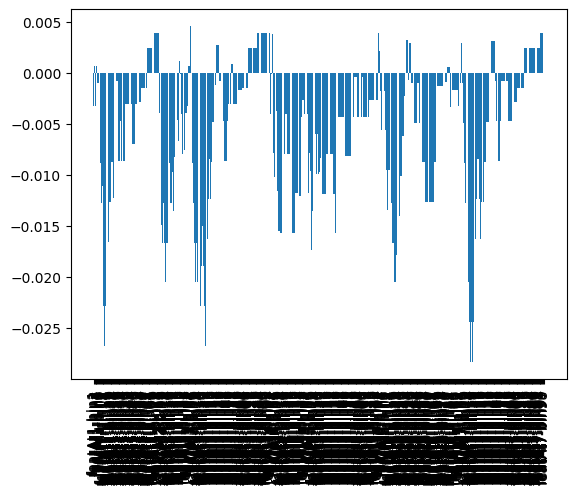

In [318]:
app_model_infbins_diffcoding_mm, app_weights_infbins_diffcoding_mm = scorecard(app_X, app_y, discretize_infbins, disc_diff_coding, margin_max)

In [319]:
app_scores_infbins_diffcoding_mm, app_accuracies_infbins_diffcoding_mm, app_AUCs_infbins_diffcoding_mm = cross_val_score(app_model_infbins_diffcoding_mm, app_X, app_y)

MSEs:  [0.2727272727272727, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.2, 0.2, 0.2, 0.2]
accuracies:  [0.7272727272727273, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8, 0.8, 0.8, 0.8]
AUCs:  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
mean MSE:  0.19818181818181818
mean accuracy:  0.8018181818181818
mean AUC:  0.5
